# Time Series Analysis

**Authors:** 
- Marc Villalonga Llobera
- Patxi Juaristi Pagegi

**Date:** 08/01/2024

---

This Jupyter Notebook covers the fourth task of the project for the Data Mining subject of the Laurea Magistrale of the University of Pisa, focused in time series analysis.

## Environment preparation and data reading

First of all, we will install all the required packages, and then import the libraries that we will use:


In [3]:
%%capture
!python -m pip install --upgrade pip
!pip install pandas
!pip install matplotlib
!pip install numpy
!pip install seaborn
!pip install sklearn
!pip install tslearn

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.utils import to_time_series_dataset
# Añadir aqui las librerias que necesitamos importar

After importing the required libraries, we will read the datasets that we have exported in the task 1, which they contain the data filtered after the data preparation tasks.

In [5]:
# Load the dataset
incidents_dataset = pd.read_csv('../project_datasets/incidents_v3.csv', low_memory=False)

## Time Series Analysis

Consider the incidents dataset and only incidents that happened in the years [2014,
2015, 2016, 2017]. Extract a time series for each city, computing for each week of the 4
years a score. The score can be an index created in one of the previous tasks or a new
one and it can be different for each subtask. Therefore, each value of the time series
(one for each city) corresponds to the score value for a certain week of 2014, 2015,
2016, 2017. You can filter the cities, excluding the ones with a low number of weeks with
incidents. For example, you can consider only cities with a number of weeks with
incidents greater than 15% of the total number of the weeks of the 4 years.

In [67]:
# Convert the 'date' column to datetime format
incidents_dataset['date'] = pd.to_datetime(incidents_dataset['date'])
# Agregar una nueva columna 'week'
incidents_dataset['week'] = incidents_dataset['date'].dt.isocalendar().week

# Filter incidents for the years 2014 to 2017
filtered_incidents = incidents_dataset[(incidents_dataset['date'].dt.year >= 2014) & (incidents_dataset['date'].dt.year <= 2017)]

# Calculate the number of weeks with incidents for each city
weekly_counts = filtered_incidents.groupby(['city_or_county', 'week']).size().reset_index(name='incident_count')

# Calculate the total number of weeks in the 4 years
total_weeks = len(set(weekly_counts['week']))  # Fix here

# Calculate the minimum number of weeks required for inclusion (e.g., 15% of total weeks)
min_weeks_required = int(0.15 * total_weeks)

# Filter cities with incidents greater than the minimum weeks required
valid_cities = weekly_counts.groupby('city_or_county')['incident_count'].count() > min_weeks_required
valid_cities = valid_cities[valid_cities].index.tolist()

# Filter the dataset to include only valid cities
filtered_incidents = filtered_incidents[filtered_incidents['city_or_county'].isin(valid_cities)]

# Now, you can compute a score for each city for each week based on your chosen index or method.
# You can replace the following line with your specific scoring logic.
city_scores = filtered_incidents.groupby(['city_or_county', 'week'])['n_participants'].mean().reset_index(name='score')

# The 'city_scores' dataframe now contains the time series for each city with the computed scores.
print(city_scores)

      city_or_county  week  score
0          Abbeville     7    2.0
1          Abbeville     8    1.0
2          Abbeville    13    1.0
3          Abbeville    16    4.0
4          Abbeville    22    1.0
...              ...   ...    ...
36583           Zion    33    6.0
36584           Zion    35    1.0
36585           Zion    37    3.0
36586           Zion    41    2.0
36587           Zion    46    4.0

[36588 rows x 3 columns]


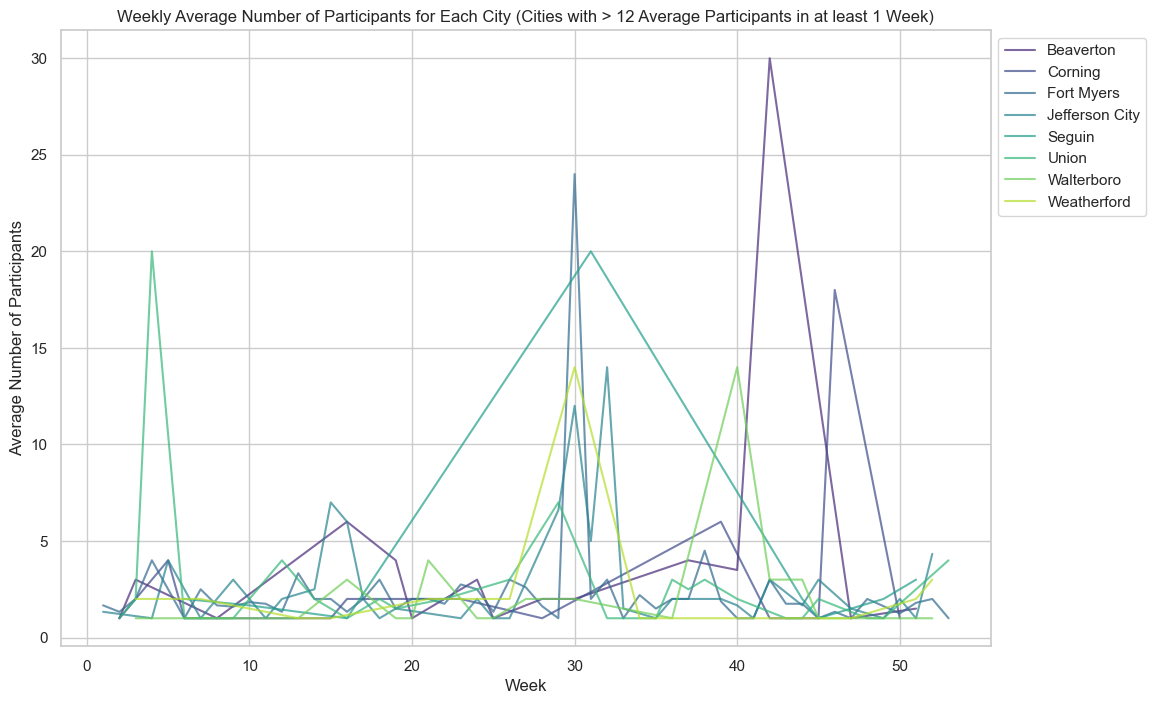

In [68]:
# Filter cities with more than 6 average participants in at least 1 week
selected_cities = city_scores.groupby('city_or_county')['score'].max() > 12
selected_cities = selected_cities[selected_cities].index

# Filter the data based on selected cities
filtered_city_scores = city_scores[city_scores['city_or_county'].isin(selected_cities)]

# Set the style of seaborn
sns.set(style="whitegrid")

# Line plot
plt.figure(figsize=(12, 8))
sns.lineplot(x='week', y='score', hue='city_or_county', data=filtered_city_scores, palette='viridis', alpha=0.7)

# Set plot labels and title
plt.xlabel('Week')
plt.ylabel('Average Number of Participants')
plt.title('Weekly Average Number of Participants for Each City (Cities with > 12 Average Participants in at least 1 Week)')

# Show the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

### Clustering and motif/anomalies extraction

The goal of this task is grouping similar cities through the use of the created time series,
based on the defined score. Analyze the results of the clustering and extract motifs and
anomalies in the time series for a deep understanding and exploration.

In [69]:
# Pivot the DataFrame to have time series data for each city
time_series_data = city_scores.pivot(index='city_or_county', columns='week', values='score').fillna(0).values

# Normalize the time series data
scaler = TimeSeriesScalerMinMax()
normalized_data = scaler.fit_transform(time_series_data)

# Reshape the data to make it 2D
num_cities, num_weeks, _ = normalized_data.shape
flattened_data = normalized_data.reshape(num_cities, -1)

# Specify the number of clusters
n_clusters = 3

# Apply K-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(flattened_data)

# Create a DataFrame with the city names and corresponding cluster assignments
cluster_df = pd.DataFrame({'city_or_county': city_scores['city_or_county'].unique(), 'cluster': clusters})

# Merge the original DataFrame with the clustering results
city_scores = pd.merge(city_scores, cluster_df, on='city_or_county', how='left')

# Visualize the clustered cities or perform additional analysis
print(city_scores)

      city_or_county  week  score  cluster
0          Abbeville     7    2.0        1
1          Abbeville     8    1.0        1
2          Abbeville    13    1.0        1
3          Abbeville    16    4.0        1
4          Abbeville    22    1.0        1
...              ...   ...    ...      ...
36583           Zion    33    6.0        1
36584           Zion    35    1.0        1
36585           Zion    37    3.0        1
36586           Zion    41    2.0        1
36587           Zion    46    4.0        1

[36588 rows x 4 columns]


C:\Users\marcl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


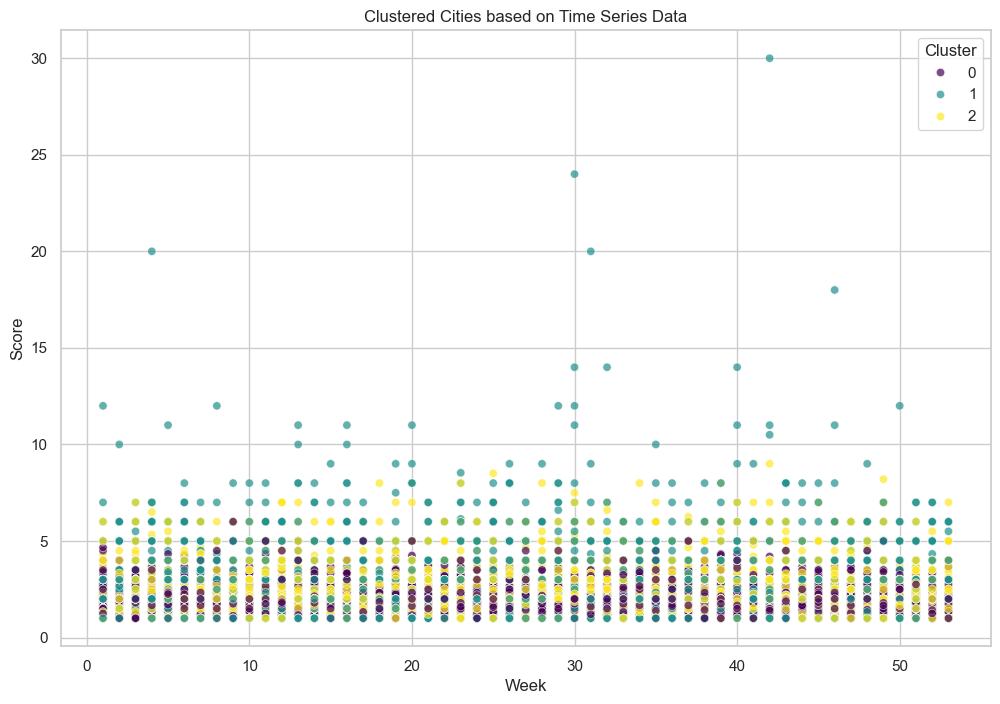

In [70]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x='week', y='score', hue='cluster', data=city_scores, palette='viridis', legend='full', alpha=0.7)

# Set plot labels and title
plt.xlabel('Week')
plt.ylabel('Score')
plt.title('Clustered Cities based on Time Series Data')

# Show legend
plt.legend(title='Cluster')

# Show the plot
plt.show()

### Shapelet extraction

Exploiting the created time series, extract the shapelet according to the class of the
binary variable isKilled.
**Note**: For this subtask there must be no relationship between the score used for the time
series and the n_killed variable, as isKilled is derived from this.

In [72]:
# Define a function to extract shapelet features for each city
def extract_shapelet_features(time_series_data):
    shapelet_features = []
    
    for city, data in time_series_data.groupby('city_or_county'):
        # Extract features specific to shapelets (you can customize this based on your needs)
        # For example, you might calculate the mean, variance, etc., of the time series for each city
        
        # Extract shapelet-related features (replace this with your actual shapelet extraction logic)
        shapelet_mean = data['score'].mean()
        shapelet_variance = data['score'].var()
        
        # Append the features to the list
        shapelet_features.append({'city_or_county': city, 'shapelet_mean': shapelet_mean, 'shapelet_variance': shapelet_variance})
    
    # Convert the list of dictionaries to a DataFrame
    shapelet_features_df = pd.DataFrame(shapelet_features)
    
    return shapelet_features_df

# Extract shapelet features
shapelet_features_df = extract_shapelet_features(city_scores)

# Merge the extracted shapelet features with the original DataFrame
city_scores_with_shapelet_features = pd.merge(city_scores, shapelet_features_df, on='city_or_county', how='left')

# Now you have a DataFrame 'city_scores_with_shapelet_features' that contains both the original time series data and the extracted shapelet features
print(city_scores_with_shapelet_features.head())


  city_or_county  week  score  cluster  shapelet_mean  shapelet_variance
0      Abbeville     7    2.0        1       2.428571           1.186813
1      Abbeville     8    1.0        1       2.428571           1.186813
2      Abbeville    13    1.0        1       2.428571           1.186813
3      Abbeville    16    4.0        1       2.428571           1.186813
4      Abbeville    22    1.0        1       2.428571           1.186813
